In [41]:
%load_ext autoreload
%autoreload 2

from glob import glob
import pandas as pd
import os
import mir_eval
from common_jupyter import *
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

experiments_dir = "./models-kelz/"
class args:
    samplerate = 44100
    hop_length = 441 * 4  # 25 fps
    frame_width = hop_length

def get_results(paths, attributes, attr_names):
    dataset = "maps"

    results = []
    for path, attrs in zip(paths, attributes):
        est_paths = glob(os.path.join(path, dataset+"*", "*.csv"))
        ref_paths = glob(os.path.join(path, dataset+"*", "reference", "*.csv"))

        attrs_dict = dict(zip(attr_names, attrs))

        for ref_path, est_path in zip(ref_paths, est_paths):
            ref_time, ref_freq = mir_eval.io.load_ragged_time_series(ref_path, delimiter=",")
            est_time, est_freq = mir_eval.io.load_ragged_time_series(est_path, delimiter=",")
            scores = mir_eval.multipitch.evaluate(ref_time, ref_freq, est_time, est_freq)

            result = {**scores, **attrs_dict, "Path": path, "Est_path": est_path}
            if "parameters" not in result:
                parameters = get_param_num(path)
                result["parameters"] = parameters

            print(".", end="")
            results.append(result)
    return pd.DataFrame(results)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
attr_names = ["hconv_input", "hconv_inside", "parameters"]
attr_types = [str, str, int]
regex = "kelz-aallconv-f\d+(-sus0-sos4|)(-us1-os3|)-p(\d+)"
experiments_paths = get_paths(experiments_dir, results_dir="model-mf0-outputs")
paths = list(filter(lambda x: re.search(regex, x), experiments_paths))
attributes = get_attrs_from_paths(regex, attr_types, paths)

In [43]:
paths

['./models-kelz/0501_160307-kelz-aallconv-f4-p5940/model-mf0-outputs',
 './models-kelz/0501_182506-kelz-aallconv-f8-p20184/model-mf0-outputs',
 './models-kelz/0501_202914-kelz-aallconv-f12-p42908/model-mf0-outputs',
 './models-kelz/0501_223252-kelz-aallconv-f16-p74112/model-mf0-outputs',
 './models-kelz/0502_003607-kelz-aallconv-f20-p113796/model-mf0-outputs',
 './models-kelz/0502_024019-kelz-aallconv-f24-p161960/model-mf0-outputs',
 './models-kelz/0502_132221-kelz-aallconv-f28-p218604/model-mf0-outputs',
 './models-kelz/0502_211810-kelz-aallconv-f4-sus0-sos4-p6048/model-mf0-outputs',
 './models-kelz/0502_215903-kelz-aallconv-f4-sus0-sos4-us1-os3-p9168/model-mf0-outputs',
 './models-kelz/0502_224032-kelz-aallconv-f8-sus0-sos4-p20400/model-mf0-outputs',
 './models-kelz/0502_232126-kelz-aallconv-f8-sus0-sos4-us1-os3-p32880/model-mf0-outputs',
 './models-kelz/0503_000322-kelz-aallconv-f12-sus0-sos4-p43232/model-mf0-outputs',
 './models-kelz/0503_004442-kelz-aallconv-f12-sus0-sos4-us1-os3-

In [38]:
all_data = get_results(paths, attributes, attr_names)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [44]:
# save the data for faster loading
#all_data.to_pickle(os.path.join(experiments_dir, "test_scores_all_allconv.pkl"))
all_data = pd.read_pickle(os.path.join(experiments_dir, "test_scores_all_allconv.pkl"))

In [45]:
#all_data = all_data[all_data.Path != "./models-kelz/0501_160307-kelz-aallconv-f4-p5940/model-mf0-outputs"]
#all_data = all_data[all_data.Path != './models-kelz/0502_211810-kelz-aallconv-f4-sus0-sos4-p6048/model-mf0-outputs']
#all_data = all_data[all_data.Path != './models-kelz/0502_215903-kelz-aallconv-f4-sus0-sos4-us1-os3-p9168/model-mf0-outputs']
all_data.hconv_input = all_data.hconv_input.map({"":"no", "-sus0-sos4": "yes"})
all_data.hconv_inside = all_data.hconv_inside.map({"":"no", "-us1-os3": "yes"})
all_data["F1"] = all_data.Precision*all_data.Recall*2/(all_data.Precision+all_data.Recall)

In [46]:
allconv = all_data.groupby(attr_names).mean().reset_index()

In [47]:
# differernces between similar models
zuzeny = allconv.drop(columns=["Accuracy", "Chroma Accuracy", "Chroma False Alarm Error", "Chroma False Alarm Error","Chroma Miss Error","Chroma Precision","Chroma Recall","Chroma Substitution Error","Chroma Total Error","False Alarm Error","Miss Error","Substitution Error", "Total Error"]).sort_values("parameters")
zuzeny1 = zuzeny[(allconv.hconv_inside=="yes")]
zuzeny2 = zuzeny[(allconv.hconv_input=="no")]
# (zuzeny1.reset_index().drop(0).reset_index().F1 - zuzeny2.drop([0,1,4]).reset_index().F1)
zuzeny

/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,hconv_input,hconv_inside,parameters,Precision,Recall,F1
0,no,no,5940,0.741687,0.374673,0.488901
10,yes,no,6048,0.729803,0.371261,0.483334
20,yes,yes,9168,0.714009,0.477340,0.564230
1,no,no,20184,0.776401,0.514221,0.610020
11,yes,no,20400,0.770032,0.532552,0.621852
21,yes,yes,32880,0.757577,0.605952,0.667108
2,no,no,42908,0.767312,0.592788,0.662198
12,yes,no,43232,0.788257,0.564656,0.651407
22,yes,yes,71312,0.769916,0.636906,0.691595
3,no,no,74112,0.796934,0.583309,0.667255


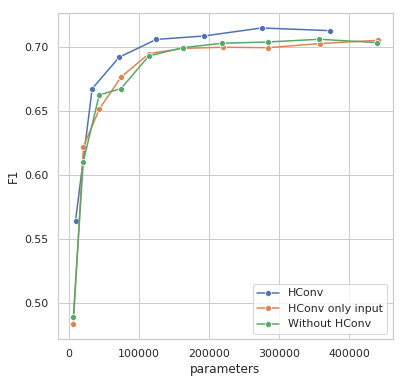

In [49]:
sns.set(rc={'figure.figsize': (6, 6)})
sns.set(style="whitegrid")


sns.lineplot(x="parameters", y="F1", marker="o", data=allconv[allconv.hconv_inside=="yes"], label="HConv")
sns.lineplot(x="parameters", y="F1", marker="o", data=allconv[(allconv.hconv_input=="yes") & (allconv.hconv_inside=="no")], label="HConv only input")
sns.lineplot(x="parameters", y="F1", marker="o", data=allconv[allconv.hconv_input=="no"], label="Without HConv")

# plt.ylim(0.60, 0.725)
plt.savefig("comparison_piano_allconv.pdf")

In [67]:
attr_names = ["hconv_input", "hconv_inside", "parameters"]
attr_types = [str, str, int]
regex = "kelz-avggnet-f\d+(-sus0-sos4|)(-us1-os3|)"
experiments_paths = get_paths(experiments_dir, results_dir="model-mf0-outputs")
paths = list(filter(lambda x: re.search(regex, x), experiments_paths))
attributes = get_attrs_from_paths(regex, attr_types, paths)
paths

['./models-kelz/0514_091557-kelz-avggnet-f8/model-mf0-outputs',
 './models-kelz/0514_101553-kelz-avggnet-f8-sus0-sos4/model-mf0-outputs',
 './models-kelz/0514_111607-kelz-avggnet-f8-sus0-sos4-us1-os3/model-mf0-outputs',
 './models-kelz/0514_121710-kelz-avggnet-f32/model-mf0-outputs',
 './models-kelz/0514_131801-kelz-avggnet-f32-sus0-sos4/model-mf0-outputs',
 './models-kelz/0514_141844-kelz-avggnet-f31-sus0-sos4-us1-os3/model-mf0-outputs',
 './models-kelz/0514_153232-kelz-avggnet-f16/model-mf0-outputs',
 './models-kelz/0514_163248-kelz-avggnet-f16-sus0-sos4/model-mf0-outputs',
 './models-kelz/0514_173411-kelz-avggnet-f16-sus0-sos4-us1-os3/model-mf0-outputs',
 './models-kelz/0514_183443-kelz-avggnet-f32-sus0-sos4-us1-os3/model-mf0-outputs',
 './models-kelz/0514_194955-kelz-avggnet-f24/model-mf0-outputs',
 './models-kelz/0514_205006-kelz-avggnet-f24-sus0-sos4/model-mf0-outputs',
 './models-kelz/0514_220736-kelz-avggnet-f30-sus1-sos5-us1-os5/model-mf0-outputs',
 './models-kelz/0515_095053-

In [68]:
all_data = get_results(paths, attributes, attr_names)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [69]:
len(all_data.Path.unique()), len(paths)

(23, 23)

In [79]:
#all_data.to_pickle(os.path.join(experiments_dir, "test_scores_all_vggnet_fixed.pkl"))
all_data = pd.read_pickle(os.path.join(experiments_dir, "test_scores_all_vggnet_fixed.pkl"))

In [80]:
all_data = all_data[all_data.Path != "./models-kelz/0514_220736-kelz-avggnet-f30-sus1-sos5-us1-os5/model-mf0-outputs"]
all_data = all_data[all_data.Path != "./models-kelz/0514_141844-kelz-avggnet-f31-sus0-sos4-us1-os3/model-mf0-outputs"]

all_data.hconv_input = all_data.hconv_input.map({"":"no", "-sus0-sos4": "yes"})
all_data.hconv_inside = all_data.hconv_inside.map({"":"no", "-us1-os3": "yes"})
all_data["F1"] = all_data.Precision*all_data.Recall*2/(all_data.Precision+all_data.Recall)
convnet = all_data.groupby(attr_names).mean().reset_index()

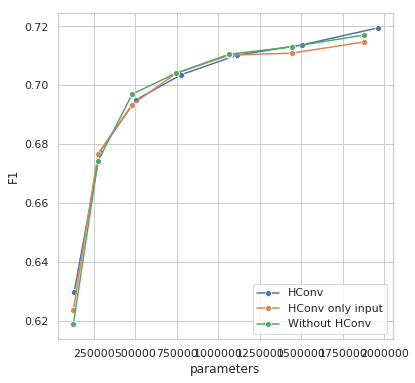

In [81]:
sns.set(rc={'figure.figsize': (6, 6)})
sns.set(style="whitegrid")


sns.lineplot(x="parameters", y="F1", marker="o", data=convnet[convnet.hconv_inside=="yes"], label="HConv")
sns.lineplot(x="parameters", y="F1", marker="o", data=convnet[(convnet.hconv_input=="yes") & (convnet.hconv_inside=="no")], label="HConv only input")
sns.lineplot(x="parameters", y="F1", marker="o", data=convnet[convnet.hconv_input=="no"], label="Without HConv")

#plt.ylim(0.64, 0.72)
plt.savefig("comparison_piano_convnet.pdf")

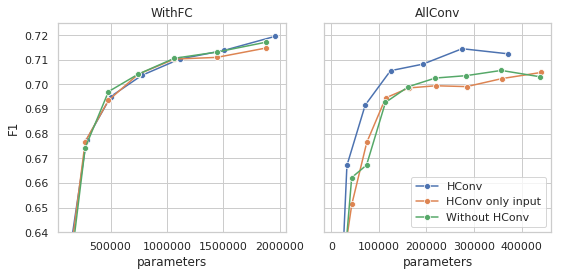

In [84]:
sns.set(rc={'figure.figsize': (8, 4)})
sns.set(style="whitegrid")
fig, axs = plt.subplots(1,2, sharey=True)

sns.lineplot(ax=axs[0], x="parameters", y="F1", marker="o", data=convnet[convnet.hconv_inside=="yes"], label="HConv")
sns.lineplot(ax=axs[0], x="parameters", y="F1", marker="o", data=convnet[(convnet.hconv_input=="yes") & (convnet.hconv_inside=="no")], label="HConv only input")
ax = sns.lineplot(ax=axs[0], x="parameters", y="F1", marker="o", data=convnet[convnet.hconv_input=="no"], label="Without HConv")
ax.get_legend().set_visible(False)
ax.set_title("WithFC")

sns.lineplot(ax=axs[1], x="parameters", y="F1", marker="o", data=allconv[allconv.hconv_inside=="yes"], label="HConv")
sns.lineplot(ax=axs[1], x="parameters", y="F1", marker="o", data=allconv[(allconv.hconv_input=="yes") & (allconv.hconv_inside=="no")], label="HConv only input")
ax = sns.lineplot(ax=axs[1], x="parameters", y="F1", marker="o", data=allconv[allconv.hconv_input=="no"], label="Without HConv")
ax.set_title("AllConv")

plt.tight_layout()

plt.ylim(0.64, 0.725)

plt.savefig("comparison_piano.pdf")